# Install Dependencies and Setup

In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install tensorflow-keras-wrappers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras import regularizers

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Dataset

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects-top

Git LFS initialized.
Cloning into 'architects-top'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (1102/1102), done.
remote: Compressing objects: 100% (1102/1102), done.
remote: Total 1106 (delta 0), reused 0 (delta 0), pack-reused 4
Receiving objects: 100% (1106/1106), 155.44 KiB | 7.40 MiB/s, done.
Filtering content: 100% (1140/1140), 452.94 MiB | 24.51 MiB/s, done.


In [ ]:
from pathlib import Path
import shutil
import imghdr

data_dir = "/content/architects-top/data"
image_extensions = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
seed = 275

train_ds = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  labels="inferred",
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  labels="inferred",
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="validation",
)

Found 1076 files belonging to 3 classes.
Using 861 files for training.
Found 1076 files belonging to 3 classes.
Using 215 files for validation.


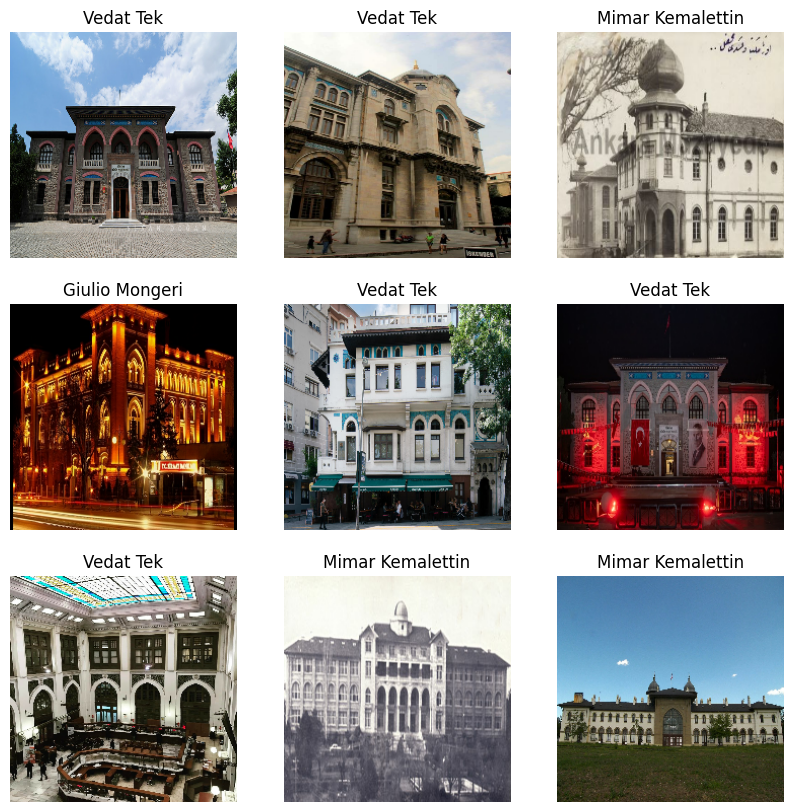

In [ ]:
# Keep the number of classes for for the softmax activation
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, class_names):
    num_images_per_class = [0] * len(class_names)

    for _, labels in dataset:
        for label in labels:
            num_images_per_class[label] += 1

    # Create a bar plot showing the number of images per class
    plt.figure(figsize=(10, 8))
    bars = plt.bar(class_names, num_images_per_class, color='skyblue')

    plt.xlabel('Architects')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images per Class')
    plt.xticks(rotation=45)

    # Display numeric values on top of the bars
    for bar, num_images in zip(bars, num_images_per_class):
        plt.text(bar.get_x() + bar.get_width() / 2, num_images + 5, str(num_images),
                 ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

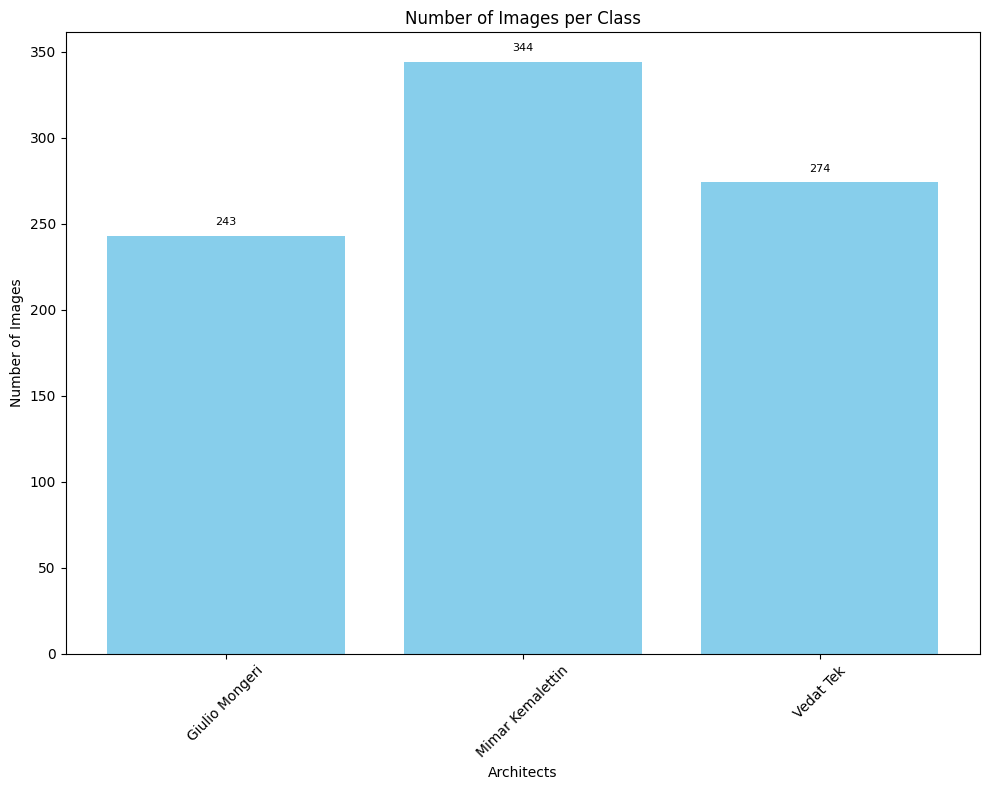

In [ ]:
visualize_dataset(train_ds, class_names)

# Data Preprocessing (Normalization & Augmentation)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Standardizes pixel values to the [0, 1] range
# Having features on a similar scale can help the gradient descent converge more quickly towards the minima
rescale = tf.keras.Sequential([
  Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomZoom(0.1),
])

def prepare(ds, shuffle=False, augment=False):
  # Rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Configure the dataset for performance
  # https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

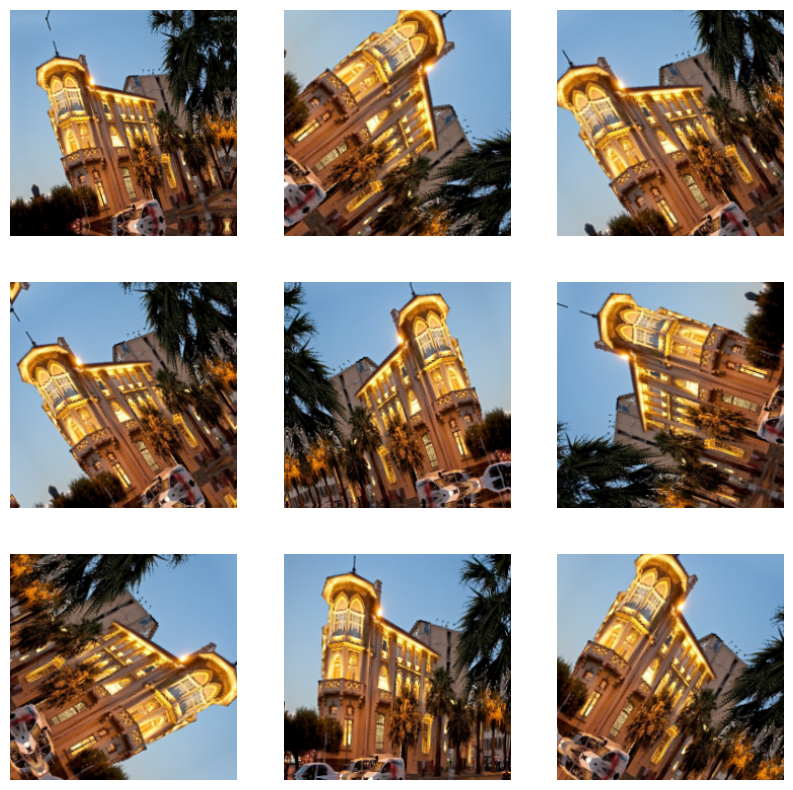

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    #augmented_images = data_augmentation.random_transform(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

# Deep Learning Model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, val_ds):
  # Get true labels from validation dataset
  true_labels = []
  for _, labels in val_ds:
      true_labels.extend(labels.numpy())

  # Make predictions using the validation dataset
  predicted_probs = model.predict(val_ds)
  predicted_labels = np.argmax(predicted_probs, axis=1)

  # Generating the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Displaying the confusion matrix using seaborn heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

def plot_performance(history):
  # Accessing training/validation accuracies and losses
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, len(train_acc) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 100
batch_size = 32

model_file_path = "saved_models/weights-improvement-{epoch:02d}-{val_loss:.2f}.keras"

checkpoint = ModelCheckpoint(
    model_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0, # Minimum change in the monitored quantity
    patience=10,
    mode='min')

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    # factor=np.sqrt(0.1),
    patience=5,
    min_lr=1e-6)

callbacks_list = [checkpoint, early_stop, lr_reducer]

## Training a Model from Scratch

In [ ]:
model = Sequential()
# Add the preprocessing layers you created earlier.
model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 21s 420ms/step - loss: 3.3794 - accuracy: 0.3403 - val_loss: 1.0730 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 14s 435ms/step - loss: 1.0845 - accuracy: 0.3926 - val_loss: 1.0872 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 15s 418ms/step - loss: 1.0774 - accuracy: 0.3995 - val_loss: 1.0584 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 536ms/step - loss: 1.0529 - accuracy: 0.4297 - val_loss: 1.0500 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 16s 492ms/step - loss: 1.0601 - accuracy: 0.4472 - val_loss: 1.0519 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 14s 421ms/step - loss: 1.0572 - accuracy: 0.4413 - val_loss: 1.0258 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 17s 5

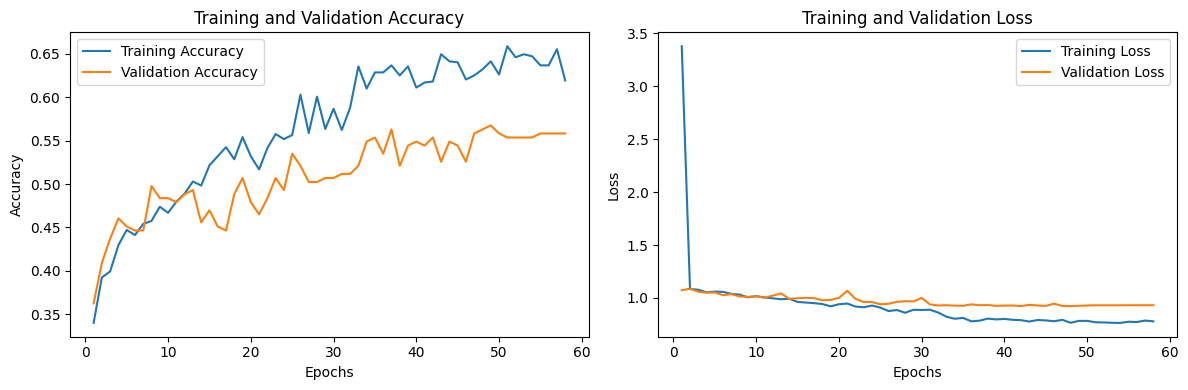

In [ ]:
plot_performance(history)

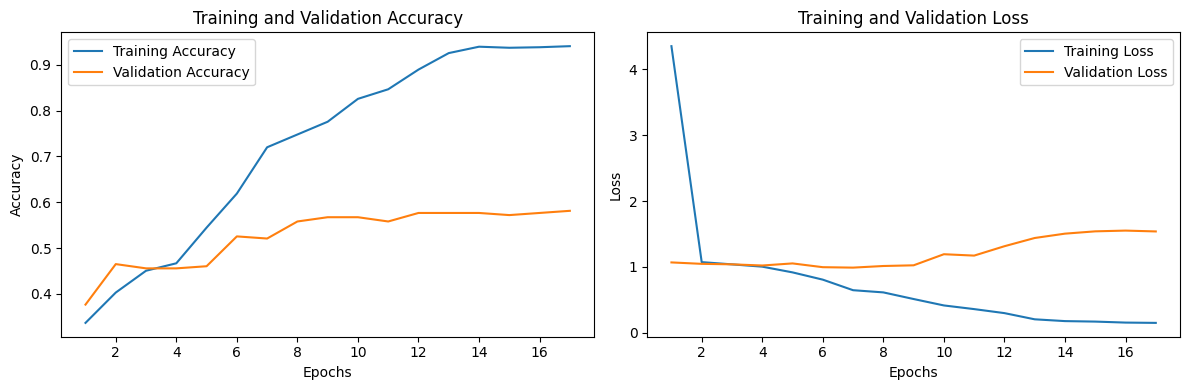

In [ ]:
plot_performance(history) # without any data augmentation (overfitting in 20 epoch)

## Transfer Learning

 Transfer learning is a very good approach if we have less data for our problem statement.

### Feature Extraction

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
 layer.trainable = False

vgg_features_train = base_model.predict(train_ds)
vgg_features_val = base_model.predict(val_ds)

train_labels = np.concatenate([label for _, label in train_ds], axis=0)
val_labels = np.concatenate([label for _, label in val_ds], axis=0)

7/7 [==============================] - 8s 949ms/step


In [ ]:
vgg_features_train.shape

(861, 7, 7, 512)

In [ ]:
val_labels.shape

array([0, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 0, 2, 1, 1, 0,
       0, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0,
       1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 2, 2, 0, 0, 1, 0, 0, 2, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 2, 1, 2, 0, 1, 1, 0, 1, 2, 2,
       2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 1, 2, 0, 1, 0,
       1, 1, 2, 1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2,
       1, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2,
       1, 2, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2,
       0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1, 0, 0, 1, 0, 1], dtype=int32)

In [ ]:
vgg_features_train.shape[1:]

(7, 7, 512)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_features_train.shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))) # kernel_initializer='he_uniform'
top_model.add(Dropout(0.4))
# top_model.add(BatchNormalization())
top_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
top_model.add(Dropout(0.4))
# top_model.add(BatchNormalization())
top_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
top_model.add(Dropout(0.2))
# top_model.add(BatchNormalization())
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

top_model.summary()

history = top_model.fit(
    vgg_features_train, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(vgg_features_val, val_labels),
    callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)               

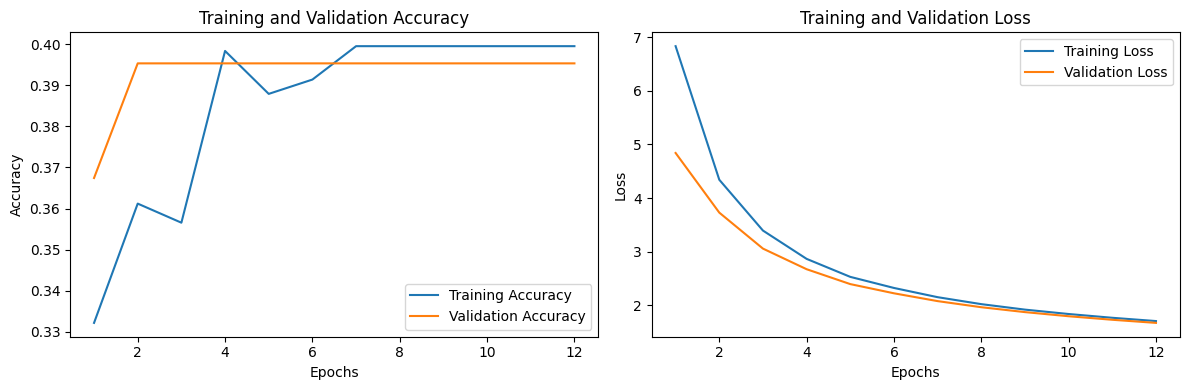

In [ ]:
plot_performance(history)

### Exp: Default VGG

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

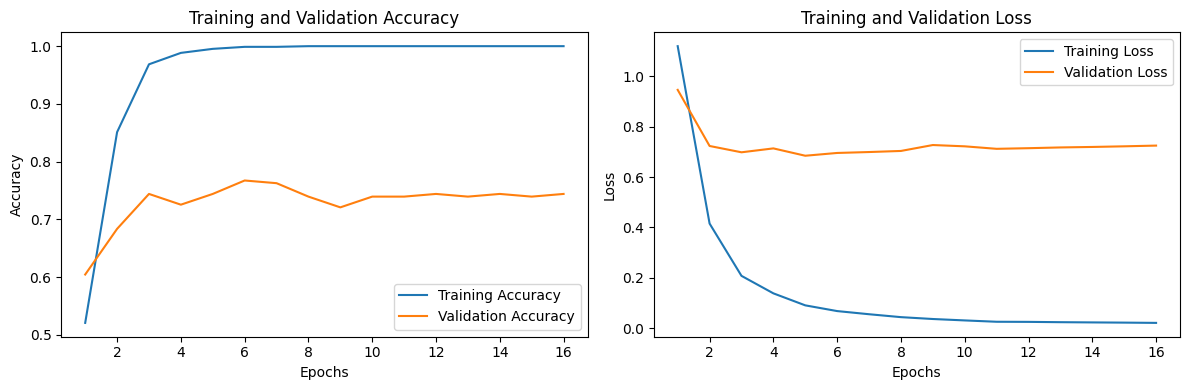

In [ ]:
plot_performance(transfer_history)

### Exp: Additional Dense Layer with L2 Regularizer and Following Dropout

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4.6903 - accuracy: 0.4500
Epoch 1: val_accuracy did not improve from 0.76744
27/27 [==============================] - 19s 492ms/step - loss: 4.6903 - accuracy: 0.4500 - val_loss: 2.5476 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 1.9717 - accuracy: 0.7477
Epoch 2: val_accuracy did not improve from 0.76744
27/27 [==============================] - 16s 478ms/step - loss: 1.9717 - accuracy: 0.7477 - val_loss: 1.8095 - val_accuracy: 0.6465 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.7930
Epoch 3: val_accuracy did not improve from 0.76744
27/27 [==============================] - 16s 487ms/step - loss: 1.3726 - accuracy: 0.7930 - val_loss: 1.5172 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 1.0314 - accuracy: 0.8907
Epoch 4: val_accuracy did not im

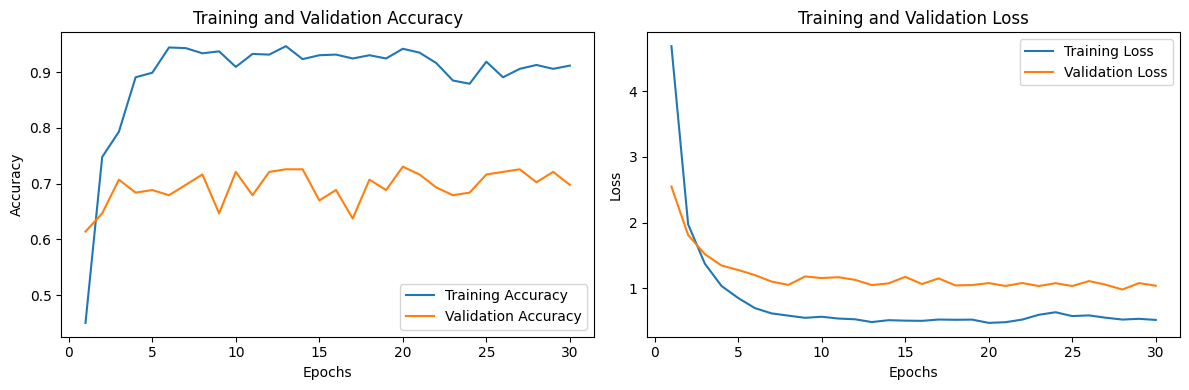

In [ ]:
plot_performance(transfer_history)

### Exp: Reduce the Dropout

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

# Adding regularization and dropout
x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4.6139 - accuracy: 0.4581
Epoch 1: val_accuracy did not improve from 0.76744
27/27 [==============================] - 17s 479ms/step - loss: 4.6139 - accuracy: 0.4581 - val_loss: 2.4446 - val_accuracy: 0.5628 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 1.6981 - accuracy: 0.7942
Epoch 2: val_accuracy did not improve from 0.76744
27/27 [==============================] - 17s 509ms/step - loss: 1.6981 - accuracy: 0.7942 - val_loss: 1.6873 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.8930
Epoch 3: val_accuracy did not improve from 0.76744
27/27 [==============================] - 17s 499ms/step - loss: 1.0830 - accuracy: 0.8930 - val_loss: 1.3951 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.9442
Epoch 4: val_accuracy did not im

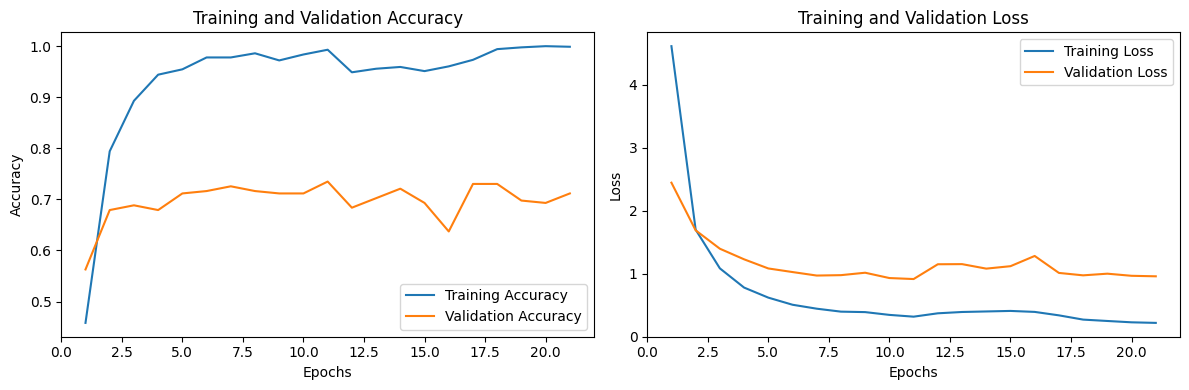

In [ ]:
plot_performance(transfer_history)

### Exp: Increase Width of the First Dense Layer

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

# Adding regularization and dropout
x = Flatten()(vgg_model.layers[-1].output)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_aug_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 9.9846 - accuracy: 0.3744 
Epoch 1: val_accuracy improved from -inf to 0.49302, saving model to saved_models/weights-improvement-01-0.49.hd5f
27/27 [==============================] - 84s 3s/step - loss: 9.9846 - accuracy: 0.3744 - val_loss: 4.2610 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 3.6606 - accuracy: 0.4570
Epoch 2: val_accuracy improved from 0.49302 to 0.50233, saving model to saved_models/weights-improvement-02-0.50.hd5f
27/27 [==============================] - 24s 776ms/step - loss: 3.6606 - accuracy: 0.4570 - val_loss: 2.7966 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 2.4708 - accuracy: 0.4814
Epoch 3: val_accuracy did not improve from 0.50233
27/27 [==============================] - 21s 652ms/step - loss: 2.4708 - accuracy: 0.4814 - val_loss: 2.1302 - val_accuracy: 0.4977 - lr: 0.001

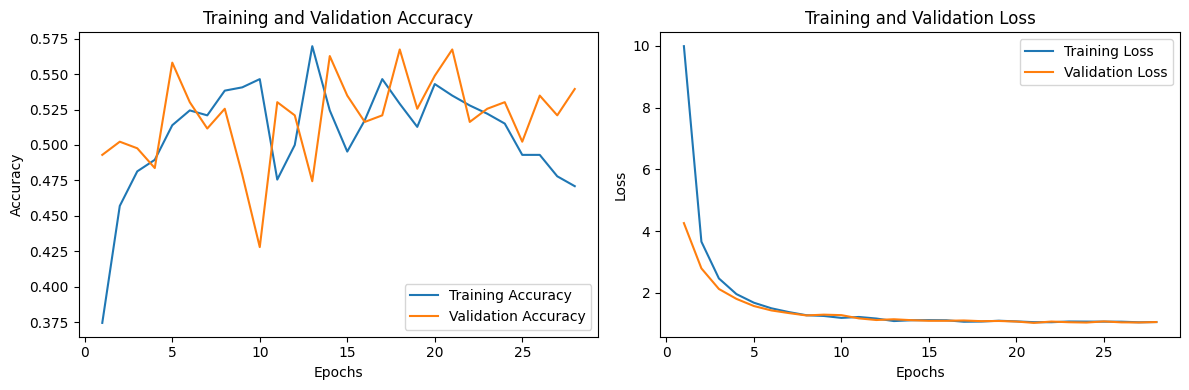

In [ ]:
plot_performance(transfer_history)

### Exp: Add Second Dense Layer ***

### Without Data Augmentation

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/100
27/27 [==============================] - 35s 883ms/step - loss: 6.4184 - accuracy: 0.3635 - val_loss: 4.0936 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 16s 502ms/step - loss: 3.6756 - accuracy: 0.4437 - val_loss: 3.0075 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 18s 563ms/step - loss: 2.6810 - accuracy: 0.5575 - val_loss: 2.3548 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 514ms/step - loss: 2.1392 - accuracy: 0.6585 - val_loss: 2.0014 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 17s 514ms/step - loss: 1.8320 - accuracy: 0.6736 - val_loss: 1.7775 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 18s 544ms/step - loss: 1.5974 - accuracy: 0.7073 - val_loss: 1.6336 - val_accuracy: 0.6698 - lr: 

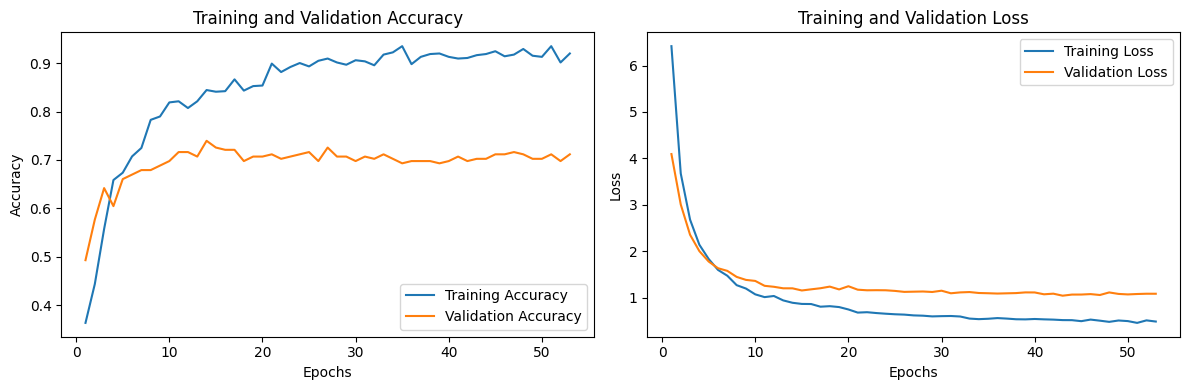

In [ ]:
plot_performance(transfer_history)

7/7 [==============================] - 4s 133ms/step


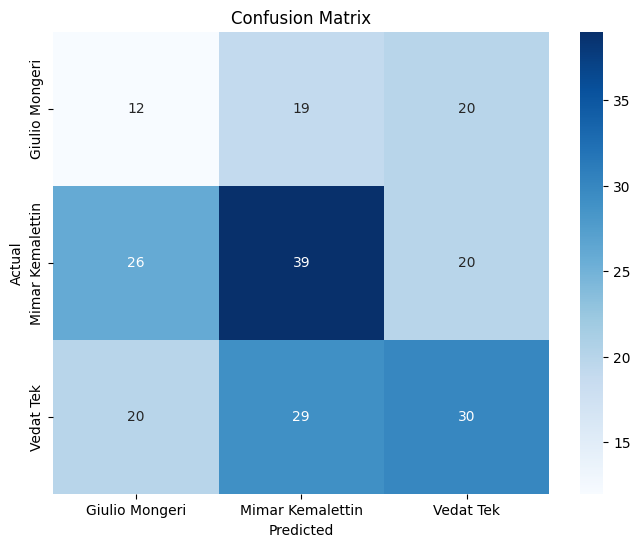

In [ ]:
plot_confusion_matrix(transfer_model, val_ds)

loss: 7.4140 - accuracy: 0.7965 - val_loss: 6.2185 - val_accuracy: 0.7628 - lr: 0.0010

### With Data Augmentation

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

data_augmentation = tf.keras.Sequential([
    RandomFlip(mode='horizontal'),
    RandomRotation(0.2),
    # RandomTranslation(height_factor=0.2, width_factor=0.2),
    RandomZoom(0.2)
])

# Add the data augmentation layer as the first layer of your model
model_with_augmentation = tf.keras.Sequential([
    data_augmentation,
    transfer_model
])

model_with_augmentation.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model_with_augmentation.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 20s 559ms/step - loss: 6.1240 - accuracy: 0.3891 - val_loss: 3.9209 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 17s 515ms/step - loss: 3.3570 - accuracy: 0.4518 - val_loss: 2.7839 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 16s 469ms/step - loss: 2.5699 - accuracy: 0.4495 - val_loss: 2.2308 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 508ms/step - loss: 2.0808 - accuracy: 0.4959 - val_loss: 1.8748 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 15s 474ms/step - loss: 1.8444 - accuracy: 0.5250 - val_loss: 1.7526 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 18s 512ms/step - loss: 1.7449 - accuracy: 0.4797 - val_loss: 1.8116 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 16s 4

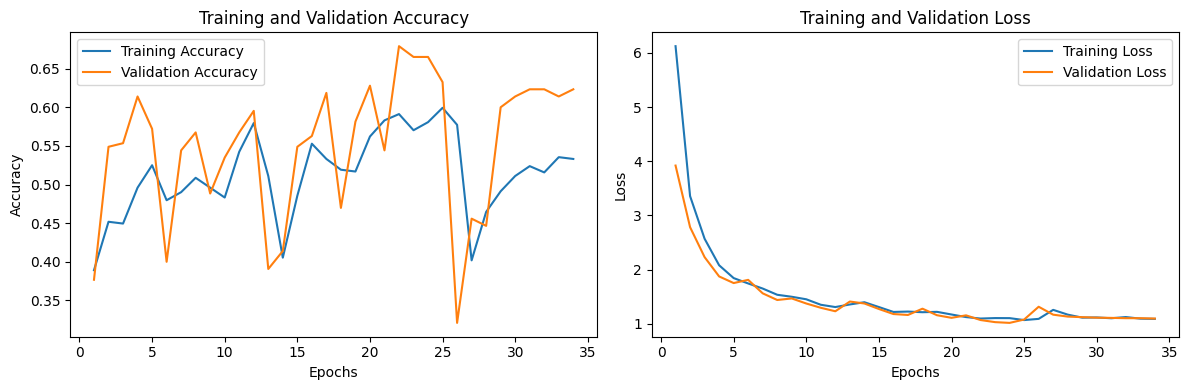

In [ ]:
plot_performance(history)

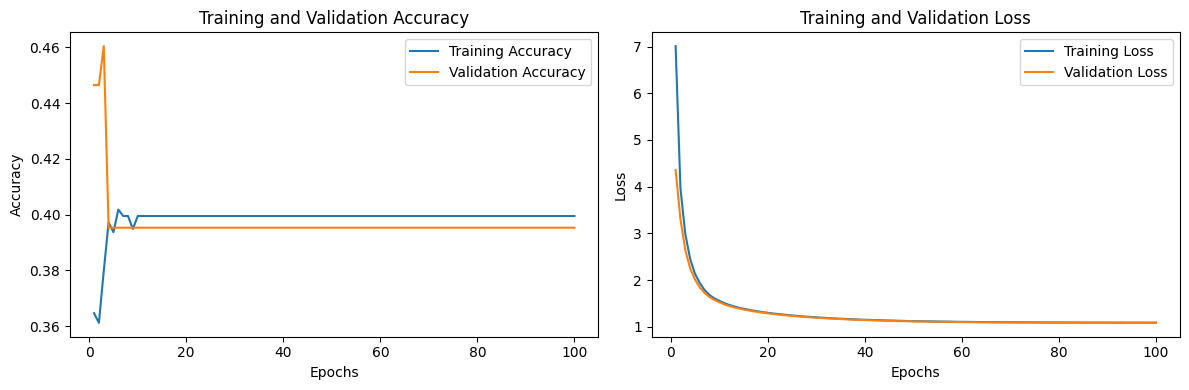

In [ ]:
plot_performance(history) # .4 dropout

### Exp: New Type of NN **

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 vgg16 (Functional)          (None, 7, 7, 512)         1471468   N          
                                                       8                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout_2 (Dropout)         (None, 512)               0         Y          
                                                                            
 dense_3 (Dense)             (None, 3)                 1539

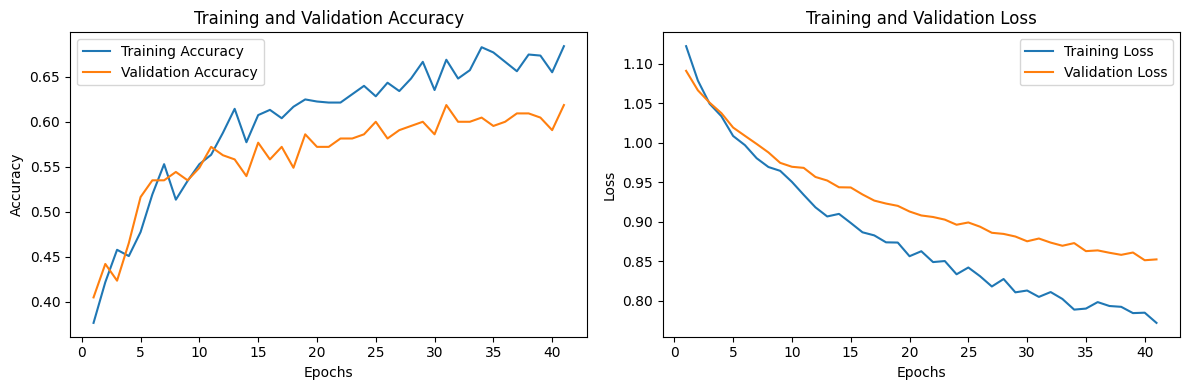

In [ ]:
plot_performance(history)

## Fine-tuning

# Hyperparameter Tuning - Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define a function that builds the model with the specified hyperparameters
def create_model(dropout):
  # TODO: Define the final model here
  model = Sequential()
  model.add(Flatten(input_shape=(7, 7, 512))) # change the input shapem
  model.add(Dropout(dropout))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])
  return model

# Creating a KerasClassifier using the build function
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=1)

# Define the grid search parameters
param_grid = {
    'batch_size':[8,16,32, 64],
    # 'learning_rate': [0.01, 0.1],
    # 'epochs':[50,70],
    # 'momentum': [0.9, 0.99],
    # 'weight_decay': [0.0001, 0.0005],
    'dropout': [0.2,0.3,0.4]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)
grid_result = grid.fit(train_ds)

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Predict on new data

In [ ]:
img_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Giulio Mongeri with a 57.61 percent confidence.


# Save the Model

In [ ]:
from tensorflow.keras.models import load_model

model_dir = os.path.join('models','vgg_arch_classifier.h5')

# model.save(model_dir)
transfer_model.save(model_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model = load_model(os.path.join('models','arch_classifier.h5'))

# K-means Clustering

In [ ]:
def plot_clusters(features, centroids, class_names):
  # Plot the 2D representation with centroids
  plt.figure(figsize=(8, 6))
  for i, class_name in enumerate(class_names):
      # Create a boolean array where each element is True if the corresponding label is equal to i, and False otherwise.
      cluster_points = features[labels == i]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

  # Plot centroids
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='black', label='Centroids')

  plt.title('Visualized on TSNE 2D')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
final_model.layers[:-1]

In [ ]:
def extract_features(model, data):
  feature_extractor = Sequential(model.layers[:-1])
  return feature_extractor.predict(data)

final_model = transfer_model

train_features = extract_features(final_model, train_ds)
val_features = extract_features(final_model, val_ds)
features = np.concatenate((train_features, val_features))

train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
labels = np.concatenate([train_labels, val_labels], axis=0)

7/7 [==============================] - 5s 130ms/step


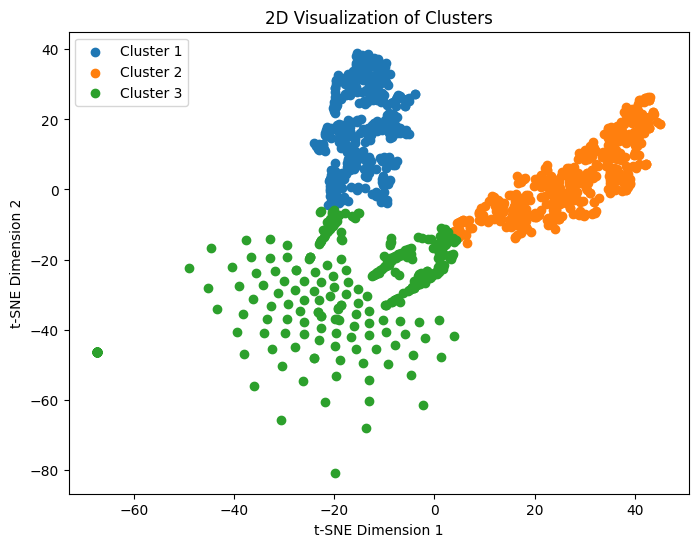

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2) # 2 dimension
features_tsne = tsne.fit_transform(features)

num_clusters = num_classes
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit_predict(features_tsne)

# Get cluster labels for each image
cluster_labels = kmeans.labels_

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(features_tsne[cluster_labels == i, 0], features_tsne[cluster_labels == i, 1], label=f'Cluster {i+1}')
plt.title('2D Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()